# Preprocessing notebooks

## Imports

In [1]:
from collections import Counter

from datasets import load_dataset
from datasets import Audio, DatasetDict, concatenate_datasets
import torch
import librosa
import numpy as np

SEED = 42
NUM_PROC = 16
SAMPLING_RATE = 16000
CHUNK_DURATION = 0.5
BATCH_SIZE = 32
THRESHOLD_AUGMENTATION = 0.8
AUGMENTE_DATASET = True
BALANCE_DATASET = True
CONVERT_TO_SPECTOGRAM = True

/home/pierre/Documents/Projects/PST4/AI/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Utils

In [8]:
def display_dataset_labels_count(_dataset: DatasetDict):
    print(f"Labels: {dataset["train"].features["label"]}")
    train_label_count = Counter(_dataset["train"]["label"])
    print(train_label_count)
    val_label_count = Counter(_dataset["val"]["label"])
    print(val_label_count)
    test_label_count = Counter(_dataset["test"]["label"])
    print(test_label_count)

def dataset_splits_info(_dataset: DatasetDict):
    print(f"Size of splits: train={len(_dataset['train'])}, val={len(_dataset['val'])}, test={len(_dataset['test'])}")

## Load base dataset

In [3]:
# Load dataset
DS = load_dataset("n1coc4cola/maotouying")
DS_train = DS["train"]

## Shuffle the dataset and select N % of the dataset, create the split, cast to SAMPLING_RATE

In [4]:
# Take only n% of the dataset
n_instance = 0.001
DS_train_shuffled = DS_train.shuffle(seed=SEED).select(range(int(n_instance * len(DS_train))))

In [5]:
train_test = DS_train_shuffled.train_test_split(test_size=0.2, seed=SEED, stratify_by_column="label")
test_val = train_test["test"].train_test_split(test_size=0.5, seed=SEED, stratify_by_column="label")
dataset = DatasetDict({
    "train": train_test["train"],
    "val": test_val["train"],
    "test": test_val["test"],
})

In [6]:
# Cast to 16khz
for split in dataset.keys():
    dataset[split] = dataset[split].cast_column("audio", Audio(sampling_rate=SAMPLING_RATE))

## Dataset info

In [9]:
dataset_splits_info(dataset)

Size of splits: train=168, val=21, test=21


## Split Dataset in chunks of n seconds

In [10]:
def split_audio_into_chunks(audio_array, chunk_duration=CHUNK_DURATION, sampling_rate=SAMPLING_RATE):
    samples_per_chunk = int(chunk_duration * sampling_rate)
    num_chunks = audio_array.shape[-1] // samples_per_chunk
    # Only split into full chunks, no padding
    chunks = [audio_array[i * samples_per_chunk:(i + 1) * samples_per_chunk]
              for i in range(num_chunks)]

    return chunks

def chunk_audio_batch(batch):
    # Process by batch to allow multi processing
    all_audios = []
    all_sampling_rates = []
    all_labels = []

    for audio, label in zip(batch["audio"], batch["label"]):
        audio_array = audio["array"]
        sampling_rate = audio["sampling_rate"]
        audio_array = torch.tensor(audio_array).float()
        chunks = split_audio_into_chunks(audio_array)

        all_audios.extend([chunk.numpy() for chunk in chunks])
        all_sampling_rates.extend([sampling_rate] * len(chunks))
        all_labels.extend([label] * len(chunks))

    return {
        "audio": all_audios,
        "label": all_labels,
    }


chunked_dataset = DatasetDict()
for split in dataset.keys():
    print(f"Chunking split: {split}, original length: {len(dataset[split])}")
    chunked_split = dataset[split].map(
        chunk_audio_batch,
        batched=True,
        num_proc=NUM_PROC,
        batch_size=BATCH_SIZE,
        remove_columns=dataset[split].column_names,
    )
    print(f"Generated split {split} length, {len(chunked_split)}")
    chunked_dataset[split] = chunked_split

Chunking split: train, original length: 168
Generated split train length, 699
Chunking split: val, original length: 21
Generated split val length, 103
Chunking split: test, original length: 21
Generated split test length, 103


In [11]:
# Test chunked split
from IPython.lib.display import Audio as AudioDisplay
instance = dataset["train"][0]
print(f"Instance is {dataset["train"].features["label"].names[instance["label"]]}")
AudioDisplay(instance["audio"]["array"], rate=SAMPLING_RATE)

Instance is drone


## Balance dataset

In [12]:
display_dataset_labels_count(chunked_dataset)

Labels: ClassLabel(names=['other', 'drone'])
Counter({0: 562, 1: 137})
Counter({0: 87, 1: 16})
Counter({0: 86, 1: 17})


In [13]:
if BALANCE_DATASET:
    balanced_dataset = DatasetDict()
    for split in chunked_dataset.keys():
        split_ds = chunked_dataset[split]
        class0 = split_ds.filter(lambda x: x["label"] == 0, num_proc=NUM_PROC)
        class1 = split_ds.filter(lambda x: x["label"] == 1, num_proc=NUM_PROC)

        n = min(len(class0), len(class1))
        class0_ds = class0.select(range(n))
        class1_ds = class1.select(range(n))

        balanced_dataset[split] = concatenate_datasets([class0_ds, class1_ds]).shuffle(seed=SEED)
else:
    balanced_dataset = dataset
dataset_splits_info(balanced_dataset)

Size of splits: train=274, val=32, test=34


In [14]:
display_dataset_labels_count(balanced_dataset)

Labels: ClassLabel(names=['other', 'drone'])
Counter({0: 137, 1: 137})
Counter({1: 16, 0: 16})
Counter({0: 17, 1: 17})


## Data Augmentation

In [15]:
def noise_injection(data, noise_factor):
    noise = np.random.randn(len(data))
    augmented_data = data + noise_factor * noise
    # Cast back to the same data type
    augmented_data = augmented_data.astype(type(data[0]))
    return augmented_data

def change_pitch(data, sampling_rate, pitch_factor):
    return librosa.effects.pitch_shift(data, sr=sampling_rate, n_steps=pitch_factor)

def frequency_mask(data, mask_width=10):
    stft = librosa.stft(data)
    freq_bins = stft.shape[0]
    f0 = np.random.randint(0, freq_bins - mask_width)
    stft[f0:f0+mask_width, :] = 0
    return librosa.istft(stft)

def time_mask(data, mask_width=10):
    d = data.copy()
    t0 = np.random.randint(0, len(d) - mask_width)
    d[t0:t0+mask_width] = 0
    return d

def dynamic_range_compression(data, threshold, ratio):
    # Simple compression: reduce amplitude above threshold
    compressed = data.copy()
    compressed[np.abs(data) > threshold] = threshold + (compressed[np.abs(data) > threshold] - threshold) / ratio
    return compressed

In [24]:
size_of_chunk = SAMPLING_RATE // 2
def augmente_batch(batch):
    rng = np.random.default_rng()
    all_audios = []
    all_labels = []

    for audio, label in zip(batch["audio"], batch["label"]):
        all_audios.append(audio)
        all_labels.append(label)

        if rng.random() > THRESHOLD_AUGMENTATION:
            r = rng.random()
            data = np.array(audio)
            if r < 0.25:
                augmented_audio = noise_injection(data, noise_factor=0.05)
            elif r < 0.50:
                augmented_audio = change_pitch(data, sampling_rate=SAMPLING_RATE, pitch_factor=2)
            elif r < 0.75:
                augmented_audio = dynamic_range_compression(data, threshold=0.05, ratio=1.0)
            else:
                augmented_audio = frequency_mask(data, mask_width=20)
                # Pad when needed
                if len(augmented_audio) != size_of_chunk:
                    augmented_audio = np.pad(augmented_audio, (0, size_of_chunk - len(augmented_audio)), "constant")

            all_audios.append(augmented_audio)
            all_labels.append(label)


    return {
        "audio": all_audios,
        "label": all_labels,
    }

if AUGMENTE_DATASET:

    print(f"Augmenting train split, length before: {len(balanced_dataset["train"])}")
    augmented_split = balanced_dataset["train"].map(
        augmente_batch,
        batched=True,
        num_proc=NUM_PROC,
        batch_size=BATCH_SIZE,
        remove_columns=balanced_dataset["train"].column_names,
    )
    print(f"Length after: {len(augmented_split)}")

    augmented_dataset = DatasetDict({
        "train": augmented_split,
        "val": balanced_dataset["val"],
        "test": balanced_dataset["test"]
    })
else:
    augmented_dataset = balanced_dataset


Augmenting train split, length before: 274


Map (num_proc=16): 100%|██████████| 274/274 [00:01<00:00, 139.90 examples/s]

Length after: 334


## Convert to spectograms

In [26]:
# -----------------------------
# Audio transforms for linear spectrogram
# -----------------------------
def convert_to_linear_spectrogram(batch):
    all_linear_db = []
    all_labels = []

    for audio, label in zip(batch["audio"], batch["label"]):
        data = np.array(audio)
        # Compute STFT
        stft = librosa.stft(data, n_fft=2048, hop_length=256)

        # Compute magnitude
        magnitude = np.abs(stft)

        # Convert to dB
        linear_db = librosa.amplitude_to_db(magnitude, ref=np.max)
        all_linear_db.append(torch.tensor(linear_db))
        all_labels.append(torch.tensor(label))

    return {
        # Convert to torch tensors
        "audio": all_linear_db,
        "label": all_labels,
    }



if CONVERT_TO_SPECTOGRAM:
    spectrogram_dataset = DatasetDict()
    for split in augmented_dataset.keys():
        print(f"Converting to spectrogram split: {split}")
        spectrogram_split = augmented_dataset[split].map(
            convert_to_linear_spectrogram,
            batched=True,
            num_proc=NUM_PROC,
            batch_size=BATCH_SIZE,
            remove_columns=augmented_dataset[split].column_names,
        )
        spectrogram_dataset[split] = spectrogram_split
else:
    spectrogram_dataset = augmented_dataset


Converting to spectrogram split: train


Map (num_proc=16): 100%|██████████| 334/334 [00:03<00:00, 103.38 examples/s]


Converting to spectrogram split: val


Map (num_proc=16): 100%|██████████| 32/32 [00:01<00:00, 17.08 examples/s]


Converting to spectrogram split: test


Map (num_proc=16): 100%|██████████| 34/34 [00:01<00:00, 18.30 examples/s]


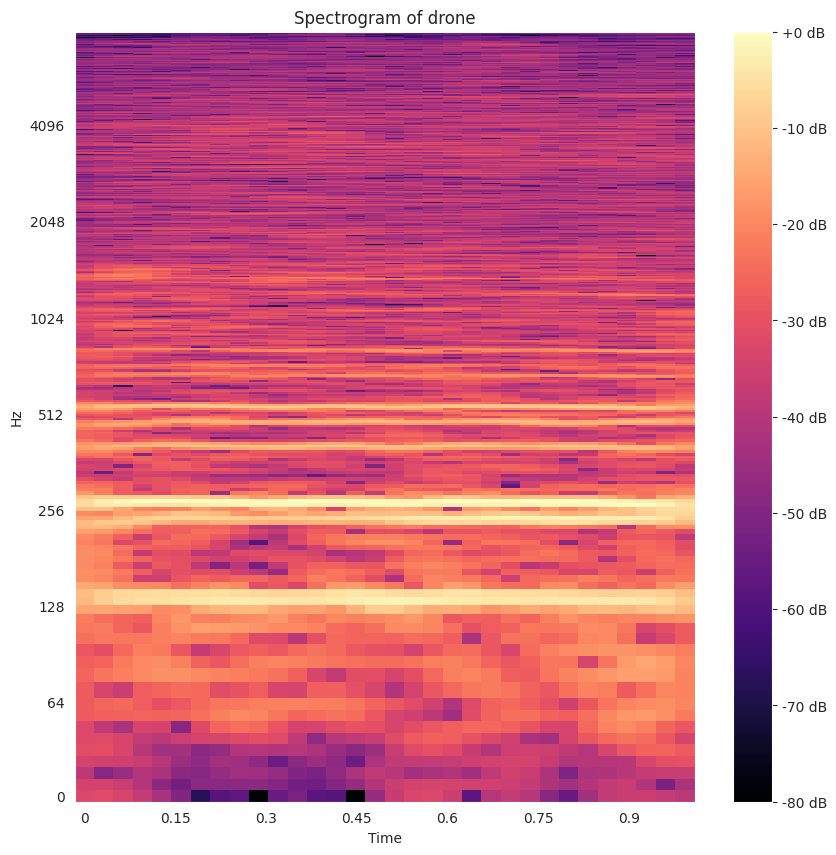

In [27]:
import matplotlib.pyplot as plt
# Debug spectogram
if CONVERT_TO_SPECTOGRAM:
    instance = spectrogram_dataset["train"][1]
    array = np.array(instance["audio"])
    plt.figure(figsize=(10, 10))
    librosa.display.specshow(array, sr=SAMPLING_RATE, x_axis="time", y_axis="log")
    plt.colorbar(format='%+2.0f dB')
    plt.title(f"Spectrogram of {spectrogram_dataset["train"].features["label"].names[instance["label"]]}")
    plt.show()


## Save to disk the dataset

In [28]:
dataset_name = f"ds_{str(n_instance).replace(".", "-")}_{"specto" if CONVERT_TO_SPECTOGRAM else "raw"}_{("aug_"+str(THRESHOLD_AUGMENTATION).replace(".", "-")) if AUGMENTE_DATASET else "noaug"}_{"balanced" if BALANCE_DATASET else "not_balanced"}_chunked.hf"
dataset_name

'ds_0-001_specto_aug_0-8_balanced_chunked.hf'

In [29]:
spectrogram_dataset.save_to_disk(f"./{dataset_name}")

Saving the dataset (1/1 shards): 100%|██████████| 34/34 [00:00<00:00, 2532.57 examples/s]
